# The goal of this notebook is to regenerate the figures in the accompanying manuscript
- In order for it to run properly, you will need to download outputs from the Zenodo repository
- Zenodo link: https://zenodo.org/records/11264203
- For this notebook in particular, you should only need to download the "processed_data.tar.gz"
# Full rundown of what is in processed_data directory:
- This folder contains outputs from cellranger (procATAC_inputs)
- Data output from ASAP_proc.R (procATAC_outputs)
- Additional data that are needed to run countASAP (countASAP_inputs)
- And the final outputs from countASAP (countASAP_outputs)

In [2]:
# Need to run this in Ipython only.
import pandas
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import glob
import gc
import umap
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
#import MEMSEAL
import anndata
from muon import MuData
from muon import prot as pt
    

################################
# This bit is for that figure formatting. Change font and font size if desired
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Lastly this custom colormap is for 
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])
cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])
################################

/home/bizon/anaconda3/envs/asap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Choose if you want to drop highly correlated vectors/genes
drop_corr = False
# Choose if you want to display PCA or UMAP dimension reduction
dimRed = 'pca'
# Choose where you want to send outputs
finDir='./'

zenodoPath = '/home/bizon/Desktop/0Manuscript_countASAP/toZenodo/'
atac_mat = pandas.read_csv(zenodoPath+'processed_data/procATAC_outputs/mat_test.csv')
atac_names = pandas.read_csv(zenodoPath+'processed_data/procATAC_outputs/gene_meta_test.csv')


# We need to process our "atac_names" to pull out just headers for columns:
gene_names = atac_names['gene_info']
copyNA = gene_names[gene_names.isna()].index

# This is probably not good practice but it works!!
# Move over chromosomal names to replace NAN where there aren't precise gene names...
gene_names.loc[copyNA] = atac_names['regions'].loc[copyNA]
# Save these just in case....
chr_regions = atac_names['regions']
atac_mat.index = gene_names


/tmp/ipykernel_488885/1180178472.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_names.loc[copyNA] = atac_names['regions'].loc[copyNA]


In [17]:
# We can drop highly correlated vectors in part to reduce the 
# size of the dataset we are processing. Didn't do for manuscript
# It does sometimes drop out columns like Cd4, as a note
def drop_corr(full_df,corr_coef=0.99):
    # We can actually really nicely remove a couple thousand genes this way...
    drop_zeros = [index for index in full_df.index if all(full_df.loc[index] == 0 )]
    # Columns will never be 0, so dont need to deal with that
    y = full_df.drop(drop_zeros,axis=0)

    # REMOVE VERY CORRELATED VECTORS (ESSENTIALLY empty vectors)
    z_pre = np.abs(np.corrcoef(y))
    z = pandas.DataFrame(z_pre,columns=y.index,index=y.index)
    # Select upper triangle of correlation matrix
    upper = z.where(np.triu(np.ones(z.shape), k=1).astype(bool))
    # If you did want to change that corr. coef. cutoff, do so here
    to_drop = [column for column in upper.columns if ( any(upper[column] > corr_coef) ) ]
    # Your final product of a parsed matrix
    parsed_mat = y.drop(to_drop, axis=0)
    return(parsed_mat)

In [6]:

# LOAD IN ASAPseq data, processed using CountASAP and HTOdemux
asap_mat = pandas.read_csv(zenodoPath+'processed_data/countASAP_outputs/proc_ASAPtest.csv',index_col=0)

ann_raw = anndata.AnnData(asap_mat)
mdata = MuData({"A": ann_raw})
pt.pp.clr(mdata['A'])
muon_norm = mdata['A'].to_df()
fin_asap = np.transpose(muon_norm)

# ALRIGHT NOW EVERYTHING SHOULD BE LOADED UP... GO INTO PROCESSING..
# So unfortunately we need to play some dirty
# tricks here to match up the columns (annoying)
col_df1 = pandas.DataFrame(fin_asap.columns)
col_df2 = pandas.DataFrame(atac_mat.columns)
holdit=[]
for col1 in col_df1.values:
    if len(col_df2[col_df2[0] == col1[0]]) != 0:
        holdit = holdit + [col1[0]]


In [23]:
#full_df = pandas.concat([fin_asap[holdit],atac_mat[holdit]],axis=0)
full_df = atac_mat[holdit]
if drop_corr:
    parsed_mat = drop_corr(full_df)
else:
    parsed_mat = full_df


In [24]:
# This *is* a parallel step, so probably should request multiple
# compute nodes for this on LOCUS...
reducer = umap.UMAP(n_components=3, n_neighbors = 100)
if dimRed == 'umap':
    init_red = reducer.fit_transform(np.transpose(parsed_mat.values))
elif dimRed == 'pca':
    # Technically this is UMAP AND PCA
    pca = PCA(n_components=10)#, svd_solver='full')
    pc_vects=pca.fit_transform(np.transpose(parsed_mat.values))
    init_red = reducer.fit_transform(pc_vects)

/home/bizon/anaconda3/envs/asap/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'PC2')

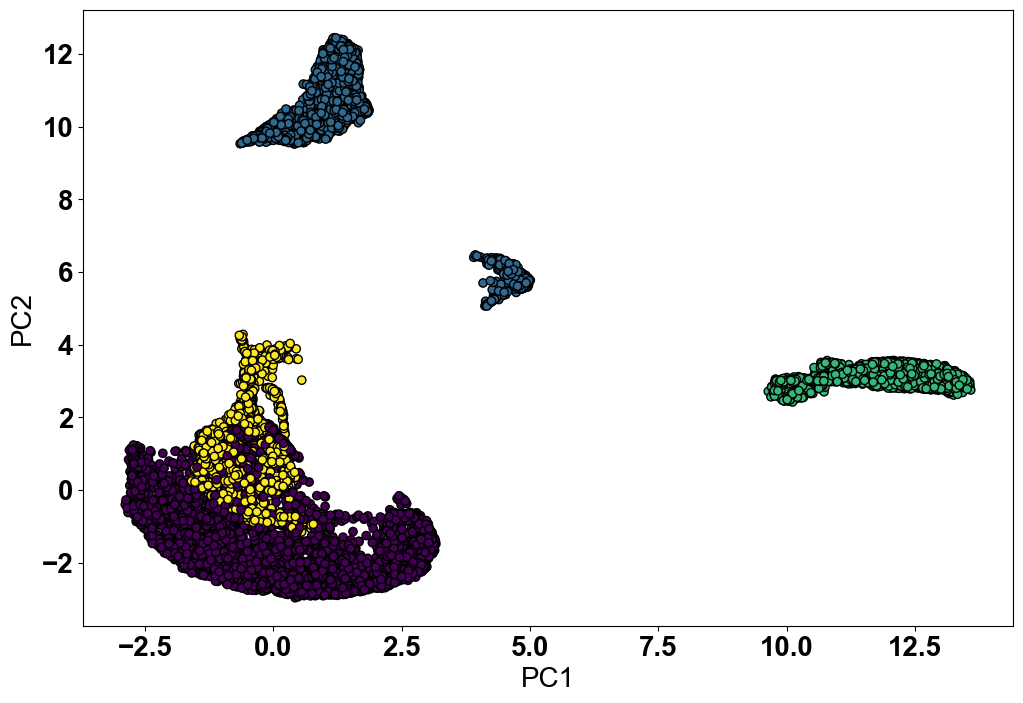

In [25]:
# Could try other clustering algorithms, but we use kmeans
#clusts = cluster.DBSCAN(min_samples=100,eps=0.5).fit_predict(init_red)
clusts = cluster.KMeans(n_clusters=4).fit_predict(init_red)
# Have this as the standard for now
#clusts = cluster.DBSCAN(min_samples=25).fit_predict(init_umap)
clust_df = pandas.DataFrame(clusts)
clust_df.index = parsed_mat.columns

# Plot all of the things that we are seeing...
# Make sure that we have good purity
clust_input=init_red#.values

fig,ax = pl.subplots(1,1,figsize = (12,8))
#x= pl.scatter(clust_input[:,0],clust_input[:,1],edgecolors='black',c=np.sum(parsed_mat.loc[['S100a9']].values,axis=0),cmap=cm.viridis,vmin=0,vmax=3)
#pl.scatter(clust_input[:,0],clust_input[:,1],edgecolors='black',c=parsed_mat.loc[['Cd8a']].iloc[0],cmap=cm.viridis)
x = pl.scatter(clust_input[:,0],clust_input[:,1],edgecolors='black',c=clust_df.values,cmap=cm.viridis)
#pl.colorbar(x)

pl.xlabel('PC1')
pl.ylabel('PC2')
#pl.savefig('figure4.png',format='png',dpi=600)

# Note: There is some stochasticity in the clustering and projection
- Because of that, the exact plots seen in Figure 4 may not be precisely recreated
- However, should be able to get the same general trends, e.g. T cell, B cell, and Myeloid clusters.
- With T cell cluster 1 being more variable in expression
- Lastly, the order in which these cells are clustered is also variable

Text(0, 0.5, 'Average Expression (Normalized)')

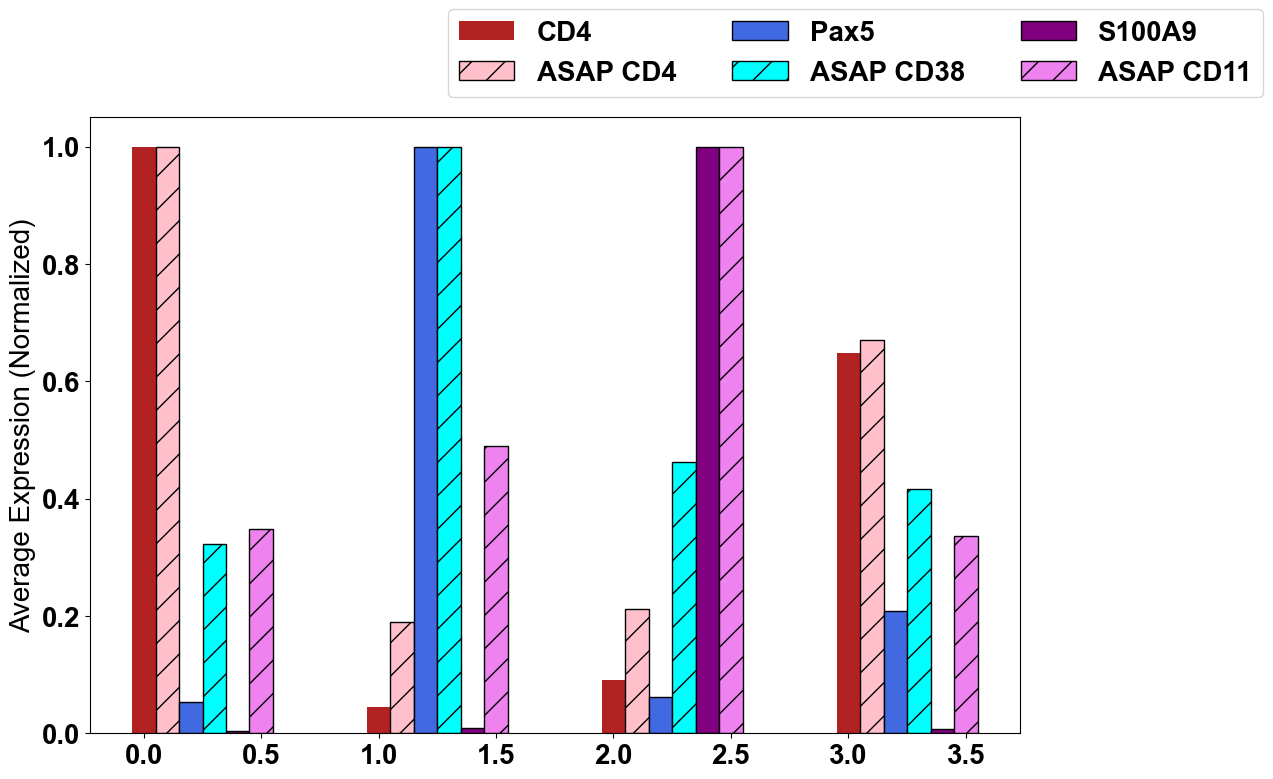

In [26]:
####################################################
# This section for plotting bar graphs:
cite_cd4 = []; cd4 = []; cite_cd8=[];cd8 = []
cite_cd11 = []; s100a9=[]; cite_H2= []; cite_cd38=[]
cite_IA = []; cite_cd3 = []; cd3 = []

std_cite_cd4 = []; std_cd4 = []; std_cite_cd8=[]; std_cd8 = []
std_cite_cd11 = []; std_s100a9=[]; std_cite_H2= []; std_cite_cd38=[]
std_cite_IA = []; std_cite_cd3 = []; std_cd3 = []
pax5 = [];hsf2=[]
for i in clust_df.drop_duplicates().sort_values(0).values:
    subF = parsed_mat[clust_df[clust_df[0]==i[0]].index]
    subF_asap = fin_asap[clust_df[clust_df[0]==i[0]].index]

    cite_cd4 = cite_cd4 + [np.average(subF_asap.loc['CD4'].values)]
    cd4 = cd4 + [np.average(subF.loc['Cd4'].values)]
    cite_cd8 = cite_cd8 + [np.average(subF_asap.loc['CD8a'].values)]
    cd8 = cd8 + [np.average(subF.loc['Cd8a'].values)]
    cite_cd3 = cite_cd3 + [np.average(subF_asap.loc['CD3'].values)]
    cd3 = cd3 + [np.average(subF.loc['Cd3e'].values)]
    cite_IA = cite_IA + [np.average(subF_asap.loc['I.A_I.E'].values)]
    cite_H2 = cite_H2 + [np.average(subF.loc['H2-DMb2'].values)]
    cite_cd38 = cite_cd38 + [np.average(subF_asap.loc['CD38'].values)]
    cite_cd11 = cite_cd11 + [np.average(subF_asap.loc['CD11b'].values)]
    s100a9 = s100a9 + [np.average(subF.loc['S100a9'].values)]
    pax5=pax5+[np.average(subF.loc['Pax5'].values)]
    hsf2=hsf2+[np.average(subF.loc['Hsf2'].values)]

pl.figure(figsize=(12,8))
pl.bar(np.arange(4)+0.0,cd4/max(cd4),width=1/10,color='firebrick')
#pl.bar(np.arange(5)+0.6,cd8/max(cd8),width=1/10,color='red')
#pl.bar(np.arange(5)+0.0,cd3/max(cd3),width=1/10,color='red',edgecolor='black')
pl.bar(np.arange(4)+0.1,cite_cd4/max(cite_cd4),width=1/10,color='pink',hatch='/',edgecolor='black')
#pl.bar(np.arange(5)+0.7,cite_cd8/max(cite_cd8),width=1/10,color='red',hatch='o')
#pl.bar(np.arange(5)+0.1,cite_cd3/max(cite_cd3),width=1/10,color='red',hatch='O',edgecolor='black')

pl.bar(np.arange(4)+0.2,pax5/max(pax5),width=1/10,color='royalblue',edgecolor='black')
pl.bar(np.arange(4)+0.3,cite_cd38/max(cite_cd38),width=1/10,color='cyan',edgecolor='black',hatch='/')

pl.bar(np.arange(4)+0.4,s100a9/max(s100a9),width=1/10,color='purple',edgecolor='black')
pl.bar(np.arange(4)+0.5,cite_cd11/max(cite_cd11),width=1/10,color='violet',edgecolor='black',hatch='/')

pl.legend(['CD4','ASAP CD4','Pax5','ASAP CD38','S100A9','ASAP CD11'],ncol=3,bbox_to_anchor=(0.37,1.01))
pl.ylabel('Average Expression (Normalized)')
#pl.savefig('asap_expression_atacOnly.pdf')

# Now, into the benchmarking.
- Benchmarking files are not included in the zenodo database, but the scripts for recreating them are.
- If you really want these files, they are available upon request
- Where applicable, some benchmarking data is included in variables in this notebook

In [3]:
# For instance, none of these files are included in the zenodo
# Needed to save space somewhere...
benchPath = '/home/bizon/Desktop/0Manuscript_countASAP/benchmarking/'
cellRanger_comp = pandas.read_csv(benchPath+'cellRanger_countMat101.csv',index_col=0)
# Note, the kallisto count missed 7 cellIDs, for some reason
kallisto_comp = pandas.read_csv(benchPath+'kb_count.csv')
kb_barcodes = pandas.read_csv(benchPath+'cells_x_features.barcodes.txt',header=None)
# Kallisto does not have the trailing -1 for comparison, need to add back
code_index = [a[0]+'-1' for a in kb_barcodes.values]
kallisto_comp.index = code_index

# This is specifically for countASAP data
# Ran it once as one big file, once as four separate lanes summed. Minimal difference
doSum = False
if doSum:
    l1 = pandas.read_csv(benchPath+'countASAP_indiLanes/101_loo1_counts.csv',index_col=0)
    l2 = pandas.read_csv(benchPath+'countASAP_indiLanes/101_loo2_counts.csv',index_col=0)
    l3 = pandas.read_csv(benchPath+'countASAP_indiLanes/101_loo3_counts.csv',index_col=0)
    l4 = pandas.read_csv(benchPath+'countASAP_indiLanes/101_loo4_counts.csv',index_col=0)
    sumLanes = l1+l2+l3+l4
else:
    sumLanes = pandas.read_csv(benchPath+'catLanes.csv',index_col=0)



# First, compare cellranger and countASAP

In [62]:
# The shape of the matrices is different. Need to reshape one of them
x = cellRanger_comp.values.reshape(210*24637)
y = np.transpose(sumLanes).values.reshape(210*24637)

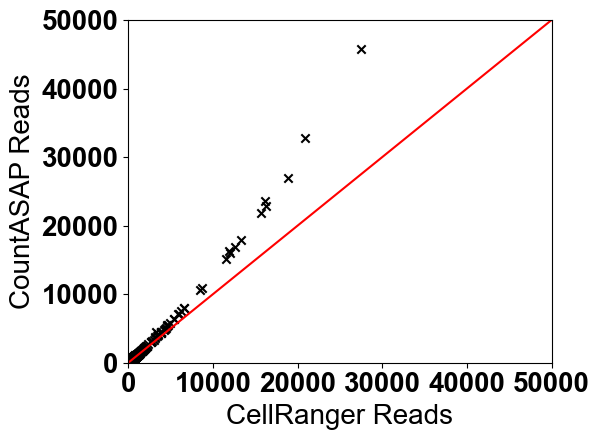

In [64]:
zoom = False
pl.scatter(x,y,marker='x',color='black')
pl.plot(np.arange(50000),np.arange(50000),color='red')

if zoom:
    pl.ylim([0,100])
    pl.xlim([0,100])
else:
    pl.ylim([0,50000])
    pl.xlim([0,50000])

pl.xlabel('CellRanger Reads')
pl.ylabel('CountASAP Reads')

pl.tight_layout()

pl.savefig('cellRanger_comp.png',format='png',dpi=600)

# Then, compare countASAP and Kallisto

In [59]:
x = kallisto_comp.values.reshape(210*24637)
y = sumLanes.values.reshape(210*24637)

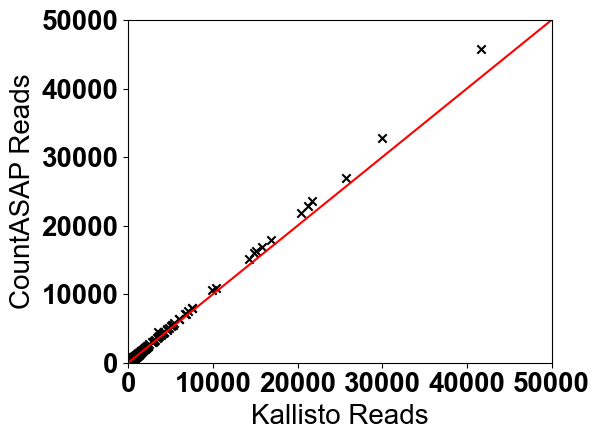

In [61]:
zoom = False
pl.scatter(x,y,marker='x',color='black')
pl.plot(np.arange(50000),np.arange(50000),color='red')

if zoom:
    pl.ylim([0,100])
    pl.xlim([0,100])
else:
    pl.ylim([0,50000])
    pl.xlim([0,50000])

pl.xlabel('Kallisto Reads')
pl.ylabel('CountASAP Reads')

pl.tight_layout()

pl.savefig('kallisto_comp.png',format='png',dpi=600)

# Now, into the scaling (processors and data size)
- Again, these numbers were just taken from the time outputs of each respective script
- Assuming no funny business from CellRanger and Kallisto

# Takeaway:
- We are 2x slower than cellranger
- Kallisto is about 10x faster than cellranger

In [12]:
# Why do they do these in mins and secs. Just give me total time in s...
# Here is the math for converting to seconds
cellRanger_times = [(37*60+1) - (28*60+32),
(41*60+54)-(37*60+11),
(46*60+32)-(42*60+4),
(51*60+10) - (46*60+48),
(55*60+49) - (51*60+21),
(60*60+29) - (55*60+59),
(5*60+6) - (39)]

cores = [1,3,6,9,18,27,36]
times = [2328.68, 1107.76, 782.632, 673.81, 570.68, 572.23, 568.93]

windows_cores = [1,2,4,6,8]
windows_time = [6261.13,3973.96,2911.74,2823.22,2779.24]

kallisto_cores = [1,3,6,9,18,27,36]
kallisto_time = [88.69, 39.32, 27.50,23.80,20.09,20.5,19.69]

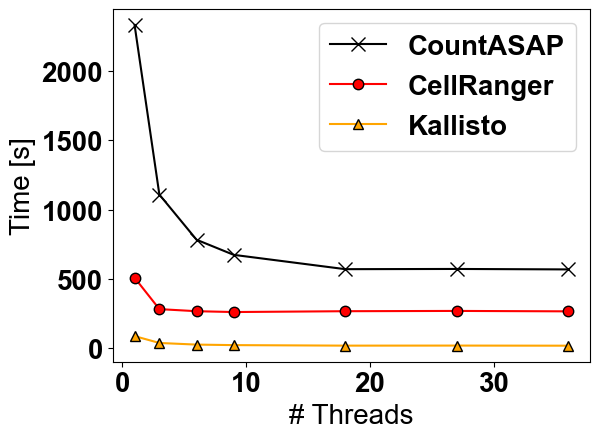

In [40]:
pl.plot(cores,times,marker='x',color='black',markeredgecolor='black',markersize=10)
pl.plot(cores,np.array(cellRanger_times),marker='o',color='red',markeredgecolor='black',markersize=7.5)

#pl.plot(cores,np.array(cellRanger_times)*2,marker='^')

#pl.plot(windows_cores,windows_time)
pl.plot(kallisto_cores,np.array(kallisto_time),marker='^',color='orange',markeredgecolor='black',
        markersize=7.5)

pl.legend(['CountASAP','CellRanger','Kallisto'])
#pl.yscale('log')
pl.ylabel('Time [s]')
pl.xlabel('# Threads')

pl.tight_layout()
pl.savefig('procScale_test.png',format='png',dpi=600)

# Now into file size scaling:
What we love to see: linear scaling.

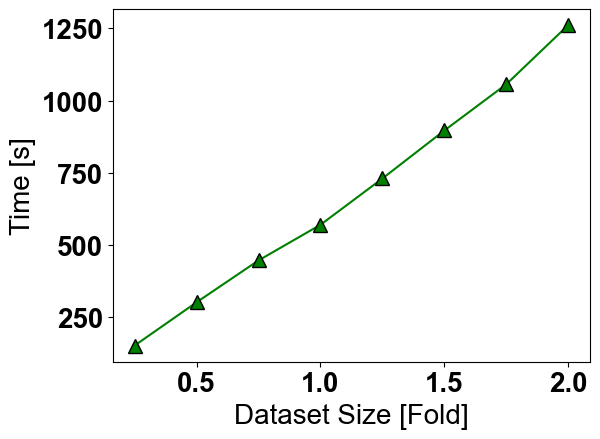

In [58]:
# procs = 24
scaleTest_size = [0.25,0.5,0.75,1,1.25,1.5,1.75,2]
scaleTest_time = [152,301.73,446.64,570,730.24,896.27,1056.41,1261.23]

pl.plot(scaleTest_size,scaleTest_time,marker='^',color='green',markeredgecolor='black',markersize=10)
pl.xlabel('Dataset Size [Fold]')
pl.ylabel('Time [s]')
pl.tight_layout()
pl.savefig('sizeScaling_asapOnly.png',format='png',dpi=600)